## This is GS 2, which is almost same to the GS 1. It means we needn't try extra times. 

In [1]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers
import tensorflow as tf
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
# Load the data
file_path = 'strength_train.dat'  # Adjust this path to your file location
df = pd.read_csv(file_path, sep='\s+', header=None, names=['Deformation', 'Temperature', 'Strength'])
train_set_temp = []
train_set_strength = []
print(len(df))
middle_temperature = df['Temperature'].median()
closest_to_middle_index = (df['Temperature'] - middle_temperature).abs().idxmin()
first_data = df.iloc[closest_to_middle_index]
first_data_temperature = first_data['Temperature']
first_data_strength = first_data['Strength']
train_set_temp.append(first_data_temperature)
train_set_strength.append(first_data_strength)
df = df.drop(closest_to_middle_index).reset_index(drop=True)


print(train_set_temp)
print(train_set_strength)


1500
[1546.0]
[3.4178994028614254]


In [2]:
for i in range (1000):
    max_dis = 0
    for j in range (len(df)):
        temp_c = df['Temperature'].values[j]
        min_dis=float('inf')
        for k in range (len(train_set_temp)):
            temp_low = train_set_temp[k]
            dis_low = abs(temp_c - temp_low)
            if dis_low < min_dis:
                min_dis = dis_low
        if min_dis > max_dis:
            max_dis = min_dis
            index_c = j
    itera_data = df.iloc[index_c]
    itera_data_temperature = itera_data['Temperature']
    temp_refer = itera_data_temperature
    itera_data_strength = itera_data['Strength']
    train_set_temp.append(itera_data_temperature)
    train_set_strength.append(itera_data_strength)
    df = df.drop(index_c).reset_index(drop=True)

print(train_set_temp)
print(train_set_strength)

[1546.0, 52.0, 3000.0, 803.0, 2273.0, 425.0, 1177.0, 1910.0, 2637.0, 614.0, 989.0, 1362.0, 235.0, 2455.0, 2091.0, 2818.0, 1730.0, 330.0, 1083.0, 897.0, 706.0, 516.0, 143.0, 2546.0, 1820.0, 2001.0, 2727.0, 1636.0, 2366.0, 2180.0, 1274.0, 1458.0, 2905.0, 1226.0, 566.0, 755.0, 1683.0, 850.0, 1036.0, 1411.0, 283.0, 1130.0, 378.0, 943.0, 2227.0, 2951.0, 660.0, 2046.0, 2773.0, 1865.0, 98.0, 2318.0, 1956.0, 2682.0, 2410.0, 2135.0, 2590.0, 187.0, 1593.0, 1777.0, 474.0, 1316.0, 1499.0, 2864.0, 2505.0, 2480.0, 730.0, 211.0, 1250.0, 1387.0, 2976.0, 258.0, 1107.0, 2750.0, 448.0, 1523.0, 1434.0, 1660.0, 2614.0, 1706.0, 543.0, 1013.0, 1753.0, 827.0, 307.0, 402.0, 778.0, 1060.0, 683.0, 1933.0, 2205.0, 1338.0, 121.0, 588.0, 2158.0, 356.0, 2433.0, 2024.0, 967.0, 2113.0, 2929.0, 2796.0, 875.0, 636.0, 1571.0, 2249.0, 1152.0, 166.0, 2297.0, 2389.0, 77.0, 1205.0, 2067.0, 2658.0, 495.0, 918.0, 1980.0, 1614.0, 1841.0, 2839.0, 1799.0, 2525.0, 2702.0, 2566.0, 1885.0, 1294.0, 2346.0, 2886.0, 1481.0, 1191.0, 343

Text(0, 0.5, 'y')

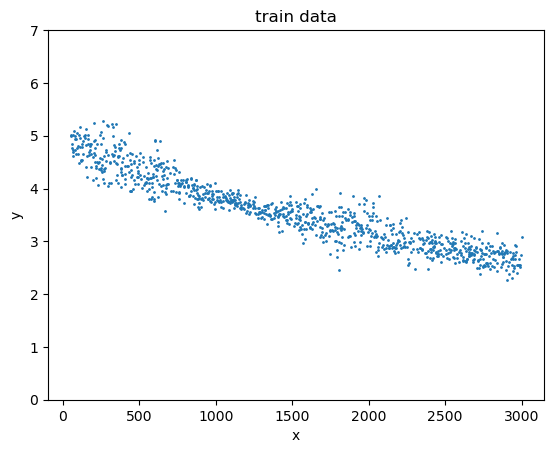

In [3]:
x = np.array(train_set_temp).reshape(-1,1)
y = np.array(train_set_strength)
poly_degree = 5
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
scaler = StandardScaler()
x_trans = poly_features.fit_transform(x)
x_trans = scaler.fit_transform(x_trans)
plt.scatter(x,y,marker='o',s=1)
plt.title("train data")
plt.ylim(0, 7)
plt.xlabel("x")
plt.ylabel("y")


In [4]:
# define loss function that corresponds to NLL  
import math
def my_NLL_loss(y_true,y_pred):
  mu=tf.slice(y_pred,[0,0],[-1,1])              # NN first output for μ     
  sigma=tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # NN second output for log(σ) 
  
  a=1/(tf.sqrt(2.*math.pi)*sigma) 
  b1=tf.square(mu-y_true)
  b2=2*tf.square(sigma)
  b=b1/b2
  
  loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
  return loss
num_set = []
mean_kl_divergence_set = []
metric_set = []
for i in range (1,500):
    checkpoint_filepath = 'best_model_GS.hdf5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
    num_train = i
    x_fit = x_trans[:num_train]
    y_fit = y[:num_train]

    model =  Sequential()
    model.add(Dense(20, activation='sigmoid',input_shape=(x_trans.shape[1],)))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(2))

    model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])

    history=model.fit(x_fit, y_fit, batch_size=16, epochs=1500,verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)

    final_epoch_metric = min(history.history['my_NLL_loss'])
    metric_set.append(final_epoch_metric)
    
    x_test = np.array([500, 1000, 1500, 2000, 2500]).reshape(-1, 1)
    x_test_trans = poly_features.transform(x_test)
    x_test_trans = scaler.transform(x_test_trans)
    
    test_mu=model.predict(x_test_trans)[:,0]
    test_log_sigma=model.predict(x_test_trans)[:,1]
    test_std = np.exp(test_log_sigma)

    mu_1 = 4.3379745025188825 
    sigma_1 = 0.31302466112124133
    mu_2 = test_mu[0]
    sigma_2 = test_std[0]
    kl_divergence_0 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5
    
    mu_1 = 3.8375629917234564 
    sigma_1 = 0.12234167681017709
    mu_2 = test_mu[1]
    sigma_2 = test_std[1]
    kl_divergence_1 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 3.450298952567952 
    sigma_1 = 0.18442226260349445
    mu_2 = test_mu[2]
    sigma_2 = test_std[2]
    kl_divergence_2 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 3.1780525543568867 
    sigma_1 = 0.2468561120320019
    mu_2 = test_mu[3]
    sigma_2 = test_std[3]
    kl_divergence_3 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 2.8908419067320454 
    sigma_1 = 0.1589833777324228
    mu_2 = test_mu[4]
    sigma_2 = test_std[4]
    kl_divergence_4 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mean_kl_divergence = np.mean([kl_divergence_0, kl_divergence_1, kl_divergence_2, kl_divergence_3, kl_divergence_4])
 
    print(num_train, mean_kl_divergence, final_epoch_metric)
    num_set.append(num_train)
    mean_kl_divergence_set.append(mean_kl_divergence)

1 204222.11637742567 -6.115302085876465
2 12759.11876580544 -10.016777038574219
3 149.36873026950292 -9.182761192321777
4 2969.7421968440785 -19.110065460205078
5 11924.80112333923 -27.304162979125977
6 881.0247561719743 -22.25742530822754
7 241.4734776361096 -16.731550216674805
8 49.0396446626054 -17.205867767333984
9 1129.8344774280865 -28.06649398803711
10 2.6370053108799043 24.64609146118164
11 1557.4008874797885 -27.87700843811035
12 37.55683276843581 -19.07682228088379
13 3441.180619694761 -22.764583587646484
14 6.004374646306074 -15.332261085510254
15 310.81995684697665 -22.929595947265625
16 1.9595109715019088 28.14349365234375
17 1.1933838415485567 -6.686356067657471
18 3.960022791977218 -7.352407455444336
19 3.481279093120347 -7.8697028160095215
20 3.3645605765627806 -7.9810967445373535
21 2.8006681384135472 -8.047599792480469
22 3.2354172306928106 -7.741197109222412
23 2.921398190868742 -7.334381103515625
24 0.688175373189851 -5.701634407043457
25 0.5908108677000142 -5.96840

KeyboardInterrupt: 

In [ ]:
x_pred=np.linspace(50,3000,5000).reshape(5000,1)

x_pred_trans = poly_features.transform(x_pred)
x_pred_trans = scaler.transform(x_pred_trans)

pred_mu=model.predict(x_pred_trans)[:,0]
pred_log_sigma=model.predict(x_pred_trans)[:,1]
plt.scatter(x[:num_train],y[:num_train],marker='o',s=1)
plt.plot(x_pred,pred_mu,c="black")

pred_1_sd_p = pred_mu+(np.exp(pred_log_sigma))
pred_1_sd_m = pred_mu-(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu+2*(np.exp(pred_log_sigma))
pred_2_sd_m = pred_mu-2*(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.3, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.3, fc='deepskyblue', ec='None')
mu_1 = 4.3379745025188825 
sigma_1 = 0.31302466112124133*2
mu_2 = 3.8375629917234564 
sigma_2 = 0.12234167681017709*2
mu_3 = 3.450298952567952 
sigma_3 = 0.18442226260349445*2
mu_4 = 3.1780525543568867 
sigma_4 = 0.2468561120320019*2
mu_5 = 2.8908419067320454 
sigma_5 = 0.1589833777324228*2
x_values = [500, 1000, 1500, 2000, 2500]
mus = [mu_1, mu_2, mu_3, mu_4, mu_5]
sigmas = [sigma_1, sigma_2, sigma_3, sigma_4, sigma_5]

for a_x, a_mu, a_sigma in zip(x_values, mus, sigmas):
    plt.errorbar(a_x, a_mu, yerr=a_sigma, fmt='o', color='red', capsize=5)
plt.title("simulated data")
plt.ylim(2, 6)
plt.xlabel("Temperature (K)")
plt.ylabel("Strength (GPa)")
plt.show()

In [ ]:
print(len(train_set_temp))